In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib


In [18]:
# Read UCI's census data sets 'adult.data' & 'adult.test'
#
features=['age','workclass','fnlwgt','education','edu_num','marital_status',
          'occupation','relationship','race','gender','capital_gain','capital_loss','hours_per_week',
          'native_country','label']
categorical_features= ['workclass','marital_status',
          'occupation','relationship','race','gender','native_country']
num_features=['age','fnlwgt','edu_num','capital_gain','capital_loss','hours_per_week']

df = pd.read_csv('adult.data',header=None,names=features) 
df1 = pd.read_csv('adult.test',header=None,names=features) 
y_train = df['label']
y_test = df1['label']
X_train = df.drop(['label','education'],axis=1)
X_test = df1.drop(['label','education'],axis=1)
model = joblib.load('model.joblib')

In [19]:
# Check out an index list of samples whose target labels are POSITIVE!
positive =np.where(np.array(y_test==' >50K'))[0]

positive[0:10]

array([ 2,  3,  7, 10, 14, 15, 19, 20, 25, 30])

### Tree Explainer

In [20]:
xt_test = model.named_steps['preprocess'].transform(X_test)

# Use shapley values to explain the xgboost model(best estimator resulting from the hyper-parameters search).
# To get meaningful insights, we sum up shapley values corresponding to one-hot encodings of a categorical feature and 
# associate that sum with the categorical feature.
#
tree_explainer = shap.TreeExplainer(model.named_steps['classifier'])
tree_shap_values = tree_explainer.shap_values(xt_test)

categorical_feature_names = model.named_steps['preprocess'].transformers_[0][2]
numerical_feature_names = model.named_steps['preprocess'].transformers_[1][2]
transformed_cat_features = model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names()
import re
d=dict()
j=0
for feature in categorical_feature_names:
    d[feature]= [i for i in range(len(transformed_cat_features)) if 'x{}_'.format(j) in transformed_cat_features[i] ]
    j +=1
a = []
for k,v in d.items():
    a.append(np.sum(tree_shap_values[:,v],axis=1))
a=np.vstack(a).transpose()
b= tree_shap_values[:,len(transformed_cat_features):]
tree_shap_values_processed = np.hstack((a,b))
X_test_processed = X_test[categorical_feature_names+numerical_feature_names]

In [21]:
# Explain a true positive instance
ind=10
shap.initjs()
shap.force_plot(tree_explainer.expected_value, tree_shap_values_processed[ind,:], X_test_processed.iloc[ind])

In [22]:
# Explain a true negative instance
ind=18
shap.initjs()
shap.force_plot(tree_explainer.expected_value, tree_shap_values_processed[ind,:], X_test_processed.iloc[ind])

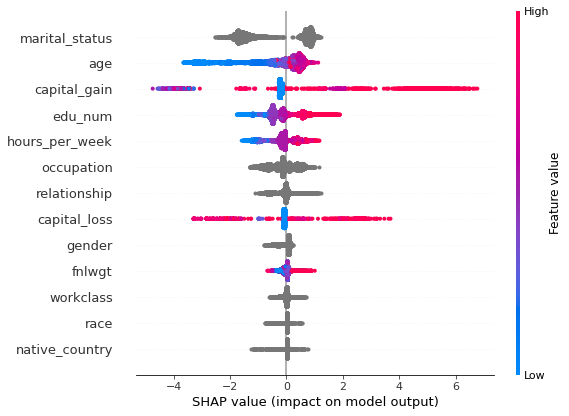

In [23]:
# summarize the effects of all the features
shap.summary_plot(tree_shap_values_processed, X_test_processed)

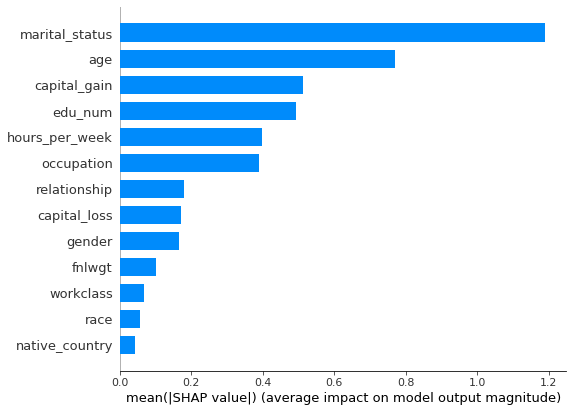

In [8]:
shap.summary_plot(tree_shap_values_processed, X_test_processed, plot_type="bar")

In [25]:
shap.force_plot(tree_explainer.expected_value, tree_shap_values_processed[0:500], X_test_processed.iloc[0:500])